# Introduction

The following dataset has een downloaded from kaggle (ref https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality?resource=download). The dataset contains attributes about a set of fruits as:

1. A_id: Unique identifier for each fruit
2. Size: Size of the fruit
3. Weight: Weight of the fruit
4. Sweetness: Degree of sweetness of the fruit
5. Crunchiness: Texture indicating the crunchiness of the fruit
6. Juiciness: Level of juiciness of the fruit
7. Ripeness: Stage of ripeness of the fruit
8. Acidity: Acidity level of the fruit
9. Quality: Overall quality of the fruit

The object of the current notebook is to develop a model ale to classify the different types of fruits. The data has been scaled and cleaned for ease of use.

# Analyzing data

In [3]:
import pandas as pd

In [4]:
apple_quality_df = pd.read_csv('apple_quality.csv')

In [5]:
apple_quality_df.describe()

A_id         Size       Weight    Sweetness  Crunchiness  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean   1999.500000    -0.503015    -0.989547    -0.470479     0.985478   
std    1154.844867     1.928059     1.602507     1.943441     1.402757   
min       0.000000    -7.151703    -7.149848    -6.894485    -6.055058   
25%     999.750000    -1.816765    -2.011770    -1.738425     0.062764   
50%    1999.500000    -0.513703    -0.984736    -0.504758     0.998249   
75%    2999.250000     0.805526     0.030976     0.801922     1.894234   
max    3999.000000     6.406367     5.790714     6.374916     7.619852   

         Juiciness     Ripeness  
count  4000.000000  4000.000000  
mean      0.512118     0.498277  
std       1.930286     1.874427  
min      -5.961897    -5.864599  
25%      -0.801286    -0.771677  
50%       0.534219     0.503445  
75%       1.835976     1.766212  
max       7.364403     7.237837

Clearly the statistics above show that the dataset has features already scaled and there are no missing values for each feature. However, oserving the data we notice that row 4000 contains non useful information therefore we remove it:

In [6]:
apple_quality_df = apple_quality_df.iloc[:4000, :]

The ojective is to classify the fruits quality ased on the other features. The possible categories are:

In [7]:
apple_quality_df["Quality"].drop_duplicates().values

array(['good', 'bad'], dtype=object)

Therefore we have a binary classification and we try to predict if the fruit is good or ad based on the available features. Let's first encode the two classed using 1 for good quality and 0 for ad quality:

In [8]:
encoding_dict = {"good": 1, "bad": 0}
apple_quality_df["Quality"] = apple_quality_df["Quality"].map(encoding_dict)

In [9]:
number_of_good_fruits = apple_quality_df["Quality"].sum()
number_of_bad_fruits = apple_quality_df["Quality"].shape[0] - number_of_good_fruits
print(f" Number good fruits: {number_of_good_fruits}, number of ad fruits {number_of_bad_fruits}")

 Number good fruits: 2004, number of ad fruits 1996


The dataset is slightly inbalanced towards the good quality class 

# Box Plots

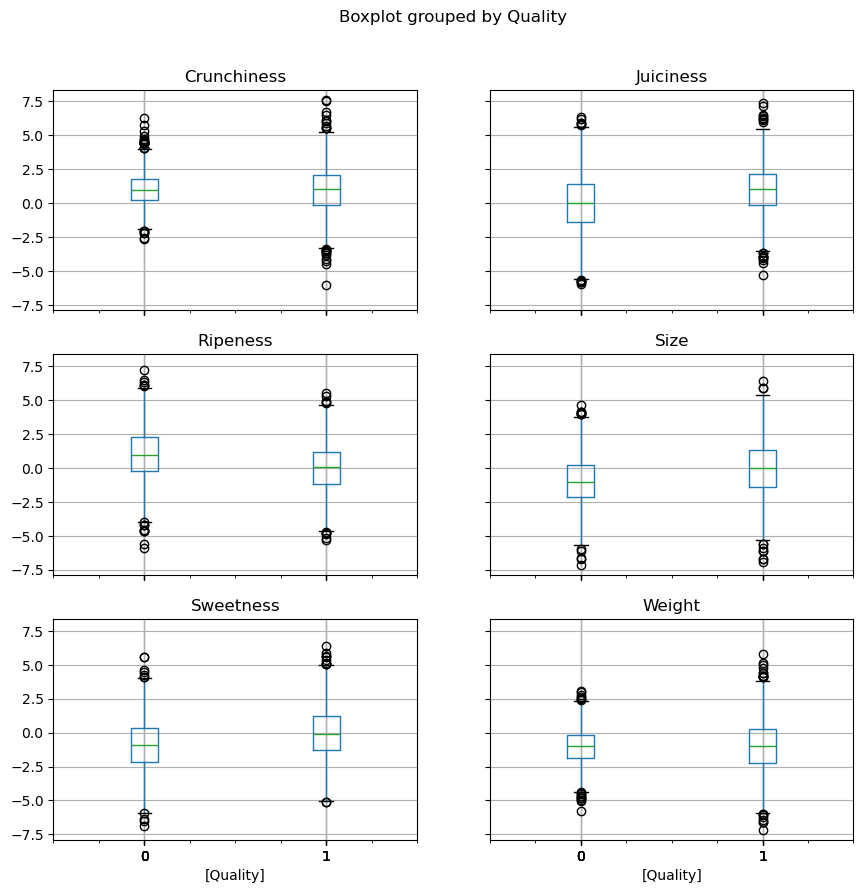

In [10]:
import matplotlib.pyplot as plt
columns = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness',
       'Ripeness', 'Acidity', 'Quality']
apple_quality_df[columns].boxplot(by="Quality", figsize=(10,10))
plt.show()

## Creation of the model features and label

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

In [12]:
feature_to_consider = ['Juiciness', 'Ripeness', 'Size', 'Sweetness']
X = apple_quality_df[feature_to_consider]

Y = apple_quality_df["Quality"]

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Baseline model predicting always the most frequent class

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import accuracy_score

In [15]:
class BaselineEstimator(BaseEstimator, RegressorMixin):
    
    """ Estimator that gives a baseline prediction for regression or classification model"""
    
    def __init__(self, mode):
        self.mode = mode
    
    def fit(self, X, y=None):
        
        if self.mode == "most frequent":
            
            counts = np.bincount(y)
            self.predicted_value = np.argmax(counts)
            
        elif self.mode == "mean":
            self.predicted_value = np.mean(y)
            
        else:
            raise Exception('Mode not supported ! (most frequent / mean)')
        
        
    def predict(self, X):
        return self.predicted_value * np.ones(X.shape[0])

In [16]:
baseline_estimator = BaselineEstimator("most frequent")
baseline_estimator.fit(X_train, Y_train)
Y_pred = baseline_estimator.predict(X_test)
print(f" Accuracy of the model predicting always the most frequent class: {accuracy_score(Y_pred, Y_test)}")

 Accuracy of the model predicting always the most frequent class: 0.48875


## Trying different types of models

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [18]:
SVC?

In [19]:
logistic_regression = LogisticRegression()
logistic_regression_param_grid = {"C": np.linspace(0.1, 2.0, num=20)}
support_vector_machine_classifier = SVC()
support_vector_param_grid = {"C": np.linspace(1, 10, 10), "kernel":['linear', 'poly', 'rbf', 'sigmoid'], "degree": [1,2,3,4]}

random_forest_classifier = RandomForestClassifier()
random_forest_param_grid = {'max_depth': np.arange(1,10)}

In [20]:
dict_cross_validation = {
    logistic_regression : logistic_regression_param_grid,
    random_forest_classifier: random_forest_param_grid,
    support_vector_machine_classifier: support_vector_param_grid
}

result = []
 
for estimator, param_grid in dict_cross_validation.items():
    gs = GridSearchCV(estimator, param_grid)

    gs.fit(X_train, Y_train)
    

    result.append((gs.best_estimator_, gs.best_score_))

In [28]:
result


[(LogisticRegression(C=0.1), 0.721875),
 (RandomForestClassifier(max_depth=9), 0.79625),
 (SVC(C=5.0, degree=1), 0.8175000000000001)]

In [22]:
final_model = result[2][0]
Y_pred = final_model.predict(X_test)

In [24]:
accuracy_score(Y_pred, Y_test)

0.82875

## Showing decision boundary

In [30]:
from sklearn.inspection import DecisionBoundaryDisplay

In [ ]:
disp = DecisionBoundaryDisplay.from_estimator(final_model, X_train, response_method="predict",
xlabel=iris.feature_names[0], ylabel=iris.feature_names[1],
alpha=0.5)

In [31]:
X_train

Juiciness  Ripeness      Size  Sweetness
542    0.164350 -1.184325 -0.172770  -0.495673
107    1.835903  0.113931  1.307057  -1.470802
3156  -2.108648 -0.418797 -0.013655  -1.956035
1291   1.166009  1.895061  0.670874   2.778495
2167   0.813084  0.786991  1.931474  -2.582810
...         ...       ...       ...        ...
1486  -0.194521 -0.310921  2.713948  -1.467581
246   -1.605194  2.963923  0.550523  -0.569825
1924   2.872311 -1.757396  0.872366  -0.190436
3992  -1.703385  3.840101  1.764253  -0.083383
2199  -1.226006  1.858117 -3.309756  -3.036953

[3200 rows x 4 columns]

In [33]:
DecisionBoundaryDisplay?

## Model Export into pickle file for future usage

In [25]:
from joblib import dump
dump(final_model, "models/svc_classifier.joblib")

['models/svc_classifier.joblib']

## Model import

In [26]:
from joblib import load
support_vector_classifier = load("models/svc_classifier.joblib")